<a href="https://colab.research.google.com/github/bmjaron/capstone/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Overview

# II. Business Understanding

Our target clientele are those who work in the politics industry, lobbyists, think tank employees, or any other individual that must read political articles for their work. In contrast to those who skim the news in their spare time, these individuals must be current with political news in order to properly complete their jobs. As such, it is necessary for them to be able to identify political articles and discard unrelated and distracting content.

Our goal is to build a model that can predict a political article given a short description of that model. This will in turn provide our cleints with the ability to pin-down their required reading with efficiency.

# III. Data Understanding

First we'll import our libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
import string
from wordcloud import WordCloud

#NLTK
import nltk
from nltk.collocations import *
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Our data comes from Kaggle ([linked here](https://www.kaggle.com/datasets/rmisra/news-category-dataset)). We want anyone who reproduces this code to be able to access the data using just their Kaggle username and API key.

In [62]:
username = input("Enter username:")

key = input("Enter API key:")

Enter username:
Enter API key:


In [3]:
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':f"{username}" ,
'key':f"{key}"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [4]:
import kaggle


In [5]:
!kaggle datasets download -d rmisra/news-category-dataset

 87% 23.0M/26.5M [00:00<00:00, 84.0MB/s]
100% 26.5M/26.5M [00:00<00:00, 80.0MB/s]


In [6]:
!unzip /content/news-category-dataset.zip

Archive:  /content/news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


In [7]:
#Load .json file
df = pd.read_json("/content/News_Category_Dataset_v3.json", lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [8]:
df.shape

(209527, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [10]:
df['category'].value_counts().head()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: category, dtype: int64

In [11]:
len(df['category'].value_counts())

42

We can see that our data set contains 209,527 news articles from the Huffington Post. Each entry is a different article containing a link, headline, category, short description, authors and date. There are 42 distinct categories of articles.

# II. EDA

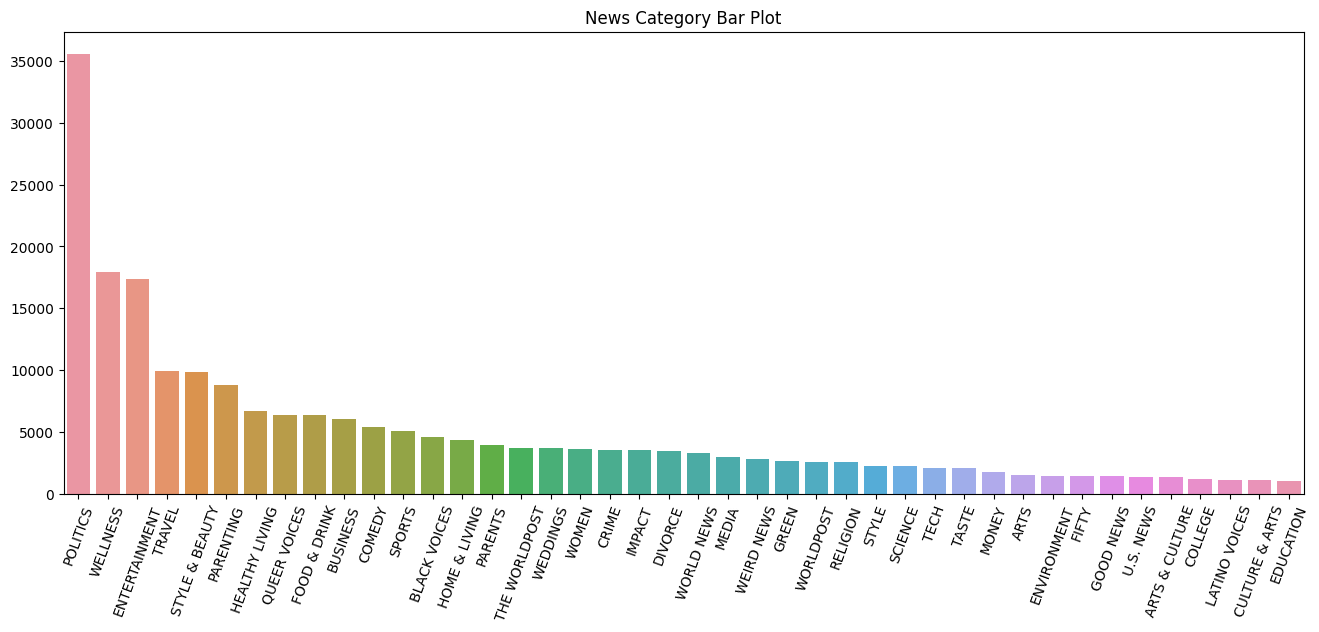

In [12]:
fig, ax = plt.subplots(figsize=(16,6))

#Barplot of different categories
sns.barplot(x=df['category'].value_counts().index,
            y=df['category'].value_counts().values)

plt.title("News Category Bar Plot")
#Rotate x-labels for visibility
plt.xticks(rotation=70);

As our goal is to predict politics articles, we'll dive into some politics specific EDA. We'll being by looking at the common authors of political articles.

In [47]:
#Separate politics from rest of data frame
df_politics = df[df['category'] == 'POLITICS']

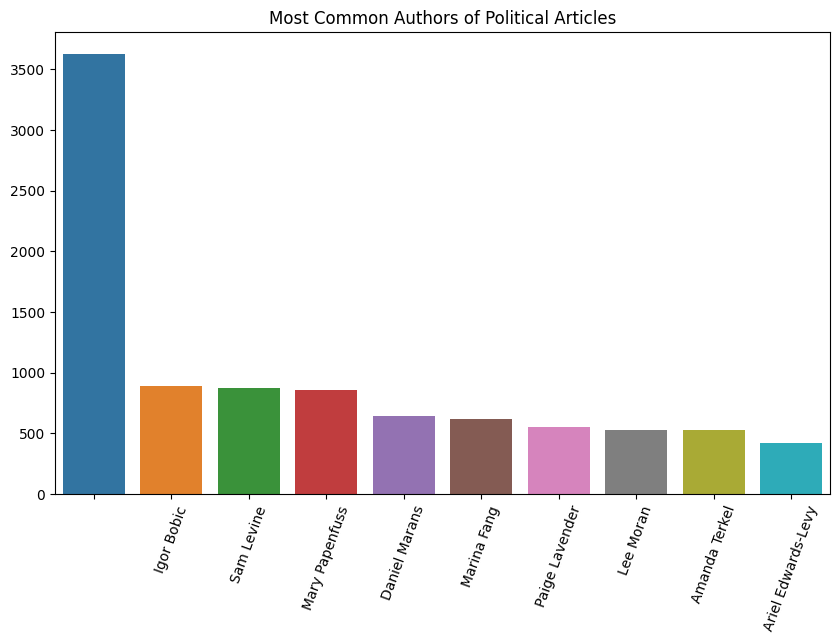

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

#Barplot of different categories
sns.barplot(x=df_politics['authors'].value_counts().head(10).index,
            y=df_politics['authors'].value_counts().head(10).values)

plt.title("Most Common Authors of Political Articles")
#Rotate x-labels for visibility
plt.xticks(rotation=70);

What stands out is that most articles do not have an author. A link to an explanation [here](https://www.quora.com/Why-do-many-BBC-articles-lack-authors) notes that oftentimes a news companies stake their reputations on the veracity of their article. As a result, the company omits an author in order to demonstrate that the article is the collective view of the company. Additionally, it could be that the entire politics team writes certain parts and there is no specific author.

# III. Two class classification

As an introduction, we're going to begin with a 2-class classification problem. We'll split the data frame into 2 categories, politics (1) or non-politics (0).

## A. Re-classifying Data

Make new dataframe.

In [50]:
#Make copy
df_2c = df.copy()

In [51]:
#Convert every category into politics (1) or not politics (0)
df_2c['category'] = df_2c['category'].map(lambda x: 1 if x == 'POLITICS' else 0)



Check the inevitable imbalance.

In [52]:
df_2c['category'].value_counts()

0    173925
1     35602
Name: category, dtype: int64

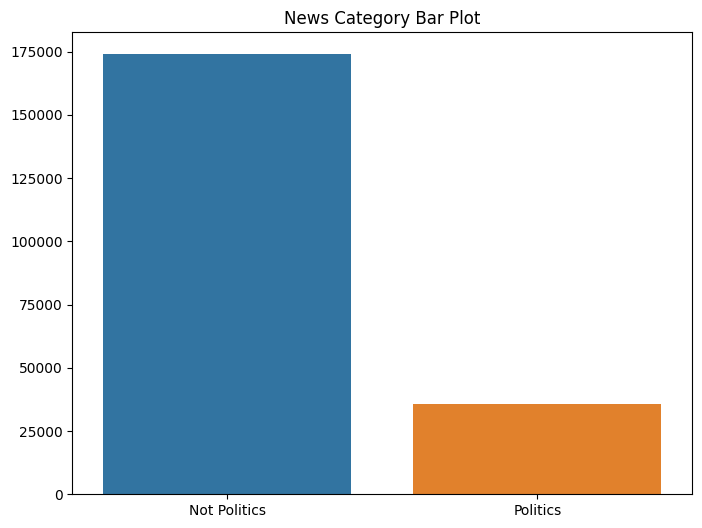

In [18]:
#Plot imbalance
fig, ax = plt.subplots(figsize=(8,6))

#Barplot of different categories
sns.barplot(x=['Not Politics', 'Politics'],
            y=df_2c['category'].value_counts().values)

plt.title("News Category Bar Plot");

There is still an incredible amount of imbalance, but we'll acount for this by randomly undersampling the majority class.

## B. Text Cleaning

Define a function to clean text ([link](https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model) to author of these regular expressions).

In [49]:
def text_cleaning(text):
  #Lowercase
  text = text.lower()
  #Strip punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('’\S+', '',text)
  text = re.sub('“\S+', '',text)
  text = re.sub('”\S+', '', text)
  return text

In [20]:
#Map function on article descriptions
df_2c['short_description'] = df_2c['short_description'].map(lambda x: text_cleaning(x))

Tokenize the text.

In [21]:
#Map NLTK tokenizer on text
df_2c['short_description'] = df_2c['short_description'].map(lambda x: nltk.word_tokenize(x))

Stopword, stemming and lemmetization.

In [23]:
#Store English stopwords as object
stop_words = stopwords.words('english')

#Map thru and remove
df_2c['short_description'] = df_2c['short_description'].map(lambda x: [word for word in x if word not in stop_words])

In [25]:
#Stem using Porter Stemmer
from nltk import PorterStemmer

stemmer = PorterStemmer()

#Map stemmer on df
df_2c['short_description'] = df_2c['short_description'].map(lambda x: [stemmer.stem(word) for word in x])

In [26]:
#Lemmatize using NLTK's WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

#Map
df_2c['short_description'] = df_2c['short_description'].map(lambda x: [wnl.lemmatize(word) for word in x])

Now, let's quickly preview our work.

In [53]:
df_2c[['short_description']].head()

,short_description
0,Health experts said it is too early to predict...
1,He was subdued by passengers and crew when he ...
2,"""Until you have a dog you don't understand wha..."
3,"""Accidentally put grown-up toothpaste on my to..."
4,Amy Cooper accused investment firm Franklin Te...


## C. Histograms and More EDA

Now that we have our data cleaned and tokenized, let's check out some histograms and such.

In [27]:
#Import necessary function from NLTK
from nltk.probability import FreqDist

In [28]:
#Make list of corpus words
corpus_words = [word for desc in df_2c['short_description'] for word in desc]

[Text(0.5, 1.0, 'Most Common Words in Corpus')]

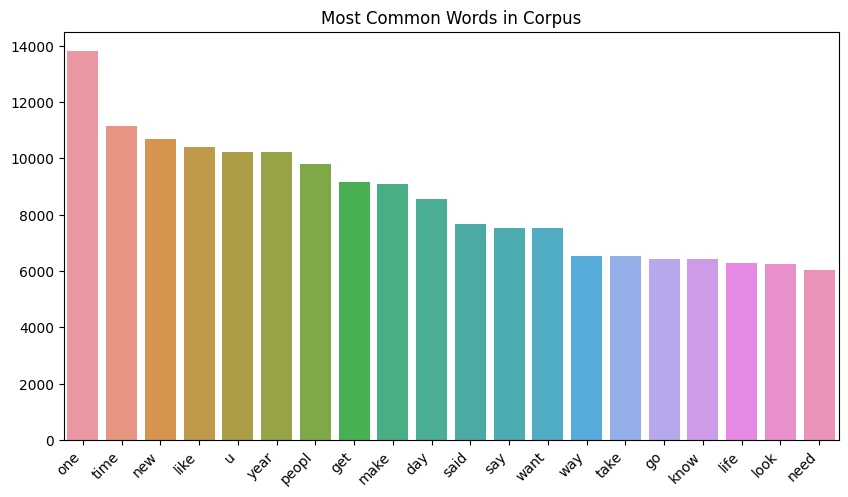

In [58]:
corpus_fdist = FreqDist(corpus_words).most_common(20)

fig, ax = plt.subplots(figsize=(10,6))
fig.autofmt_xdate(rotation=45)

sns.barplot(x=[tup[0] for tup in corpus_fdist],
            y=[tup[1] for tup in corpus_fdist],
            ax=ax).set(title='Most Common Words in Corpus');

Compare histograms of most common words, per category.

In [30]:
#Make word corpuses for category
politics_words = [word for desc in df_2c[df_2c['category'] == 1]['short_description'] for word in desc]
non_politics_words = [word for desc in df_2c[df_2c['category'] == 0]['short_description'] for word in desc]

In [31]:
#Make and plot histograms
politics_fdist = FreqDist(politics_words).most_common(20)
non_politics_fdist = FreqDist(non_politics_words).most_common(20)


[Text(0.5, 1.0, 'Most Common Words in Non-politics Tweets')]

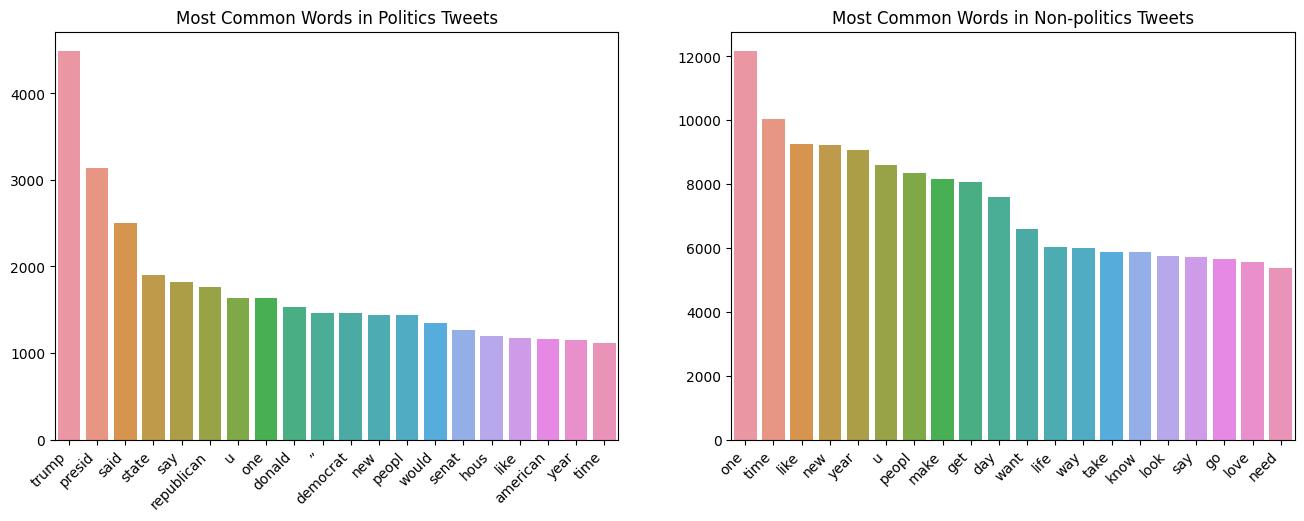

In [32]:
#Plot side by side
fig, axes = plt.subplots(1,2, figsize=(16, 6))
fig.autofmt_xdate(rotation=45)

sns.barplot(x=[tup[0] for tup in politics_fdist],
            y=[tup[1] for tup in politics_fdist],
            ax=axes[0]).set(title='Most Common Words in Politics Tweets')

sns.barplot(x=[tup[0] for tup in non_politics_fdist],
            y=[tup[1] for tup in non_politics_fdist],
            ax=axes[1]).set(title='Most Common Words in Non-politics Tweets')

## D. Initial Modeling

Split data into training, testing and holdout sets.

In [33]:
X = df_2c[['short_description']]
y = df_2c['category']

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=0)

#Spit train into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)

Synthetic undersampling of majority class.

In [35]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1, random_state=0)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Vectorize data to prepare for modeling.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorizer = TfidfVectorizer()


In [38]:
X_train_rus_vectorized = X_train_rus['short_description'].map(lambda x: ' '.join(word for word in x))
X_test_vectorized = X_test['short_description'].map(lambda x: ' '.join(word for word in x))

X_train_rus_vec = vectorizer.fit_transform(X_train_rus_vectorized)
X_test_vec = vectorizer.transform(X_test_vectorized)

In [39]:
X_train_rus_vectorized = pd.DataFrame(data = X_train_rus_vec.toarray(),
                                      columns = vectorizer.get_feature_names_out())
X_test_vectorized = pd.DataFrame(data = X_test_vec.toarray(),
                                 columns = vectorizer.get_feature_names_out())

X_train_rus_vectorized.index = X_train_rus['short_description']
X_test_vectorized.index = X_test['short_description']


### i. Baseline logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_rus_vectorized, y_train_rus)

LogisticRegression()

In [41]:
y_train_pred_1 = lr.predict(X_train_rus_vectorized)
y_test_pred_1 = lr.predict(X_test_vectorized)

In [42]:
from sklearn.metrics import classification_report

print("Training Classification Report")
print(classification_report(y_train_rus, y_train_pred_1))
print()
print("--------------------------------------------------------")
print()
print("Testing Classification Report")
print(classification_report(y_test, y_test_pred_1))

Training Classification Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     19953
           1       0.89      0.77      0.83     19953

    accuracy                           0.84     39906
   macro avg       0.84      0.84      0.84     39906
weighted avg       0.84      0.84      0.84     39906


--------------------------------------------------------

Testing Classification Report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     32607
           1       0.51      0.72      0.59      6680

    accuracy                           0.83     39287
   macro avg       0.72      0.79      0.75     39287
weighted avg       0.86      0.83      0.84     39287



Run a naive Bayes' classifier.

### ii. Multinomial Bayes' classifier

In [43]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train_rus_vectorized, y_train_rus)

MultinomialNB()

In [44]:
y_train_pred_2 = mnb.predict(X_train_rus_vectorized)
y_test_pred_2 = mnb.predict(X_test_vectorized)

In [45]:
print("Training Classification Report")
print(classification_report(y_train_rus, y_train_pred_2))
print()
print("--------------------------------------------------------")
print()
print("Testing Classification Report")
print(classification_report(y_test, y_test_pred_2))

Training Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     19953
           1       0.86      0.80      0.83     19953

    accuracy                           0.83     39906
   macro avg       0.84      0.83      0.83     39906
weighted avg       0.84      0.83      0.83     39906


--------------------------------------------------------

Testing Classification Report
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     32607
           1       0.46      0.76      0.57      6680

    accuracy                           0.81     39287
   macro avg       0.70      0.79      0.73     39287
weighted avg       0.86      0.81      0.83     39287



# IV. Multiclass Classification

In [46]:
df_mc = df.copy()

In [61]:
#Preview most common categories
df_mc['category'].value_counts().head()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: category, dtype: int64